# Variational Autoencoder for Audio
In this notebook, I will attempt to implement a VAE for generating similar sounds as those in a Spoken Digit audio Database. 

In [1]:
%matplotlib inline
import IPython.display

import gzip
import cPickle as pickle
import pandas as pd
import random
import seaborn
import librosa
import numpy as np
from matplotlib import pyplot as plt

from librosa.display import waveplot, specshow
seaborn.set(style='ticks')

In [2]:
dbfile ='../SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)    

File loaded as ../SpokenDigitDB.pkl.gz


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509 entries, 0 to 4508
Data columns (total 7 columns):
Class        4509 non-null category
Magnitude    4509 non-null object
PShift       4509 non-null int64
Phase        4509 non-null object
SIndex       4509 non-null int64
TStretch     4509 non-null float64
Wave         4509 non-null object
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 215.9+ KB


Maximum length is: 138 


(array([  60.,   63.,  123.,  138.,  123.,  180.,  177.,  180.,  186.,
         135.,  276.,  171.,  255.,  216.,  195.,  174.,  174.,  132.,
         111.,  156.,  225.,  126.,  162.,   90.,   90.,   54.,   27.,
          72.,   42.,   33.,   75.,   57.,   39.,   42.,   15.,   33.,
          15.,   12.,    9.,    6.,    6.,    3.,    3.,   12.,    3.,
           3.,    9.,    3.,    9.,    9.]),
 array([  33. ,   35.1,   37.2,   39.3,   41.4,   43.5,   45.6,   47.7,
          49.8,   51.9,   54. ,   56.1,   58.2,   60.3,   62.4,   64.5,
          66.6,   68.7,   70.8,   72.9,   75. ,   77.1,   79.2,   81.3,
          83.4,   85.5,   87.6,   89.7,   91.8,   93.9,   96. ,   98.1,
         100.2,  102.3,  104.4,  106.5,  108.6,  110.7,  112.8,  114.9,
         117. ,  119.1,  121.2,  123.3,  125.4,  127.5,  129.6,  131.7,
         133.8,  135.9,  138. ]),
 <a list of 50 Patch objects>)

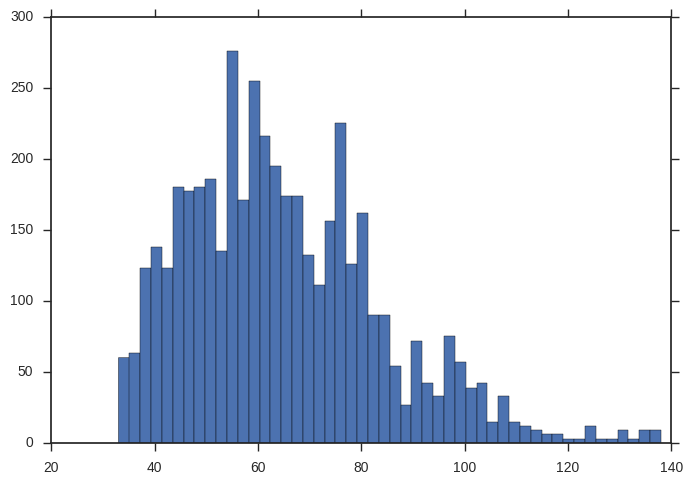

In [4]:
mag = df.Magnitude
mgs = [np.shape(x)[1] for x in mag]
maxlen = np.max(mgs)
print('Maximum length is: {} '.format(maxlen))
plt.hist(mgs,50)

In [5]:
# Padding & Truncating
maxlen = 84
# pad    = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.zeros([a.shape[0],n - a.shape[1]])))
pad    = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.min(a[:])*np.ones([a.shape[0],n - a.shape[1]])))

df.Magnitude = df.Magnitude.apply(pad,args=(maxlen,))  # MaxLen Truncation Voodoo :D
df.Phase     = df.Phase.apply(pad,args=(maxlen,))

print(np.unique([np.shape(x)[1] for x in df.Magnitude]))
print(np.unique([np.shape(x)[1] for x in df.Phase]))

[84]
[84]


## Plot Samples from Database

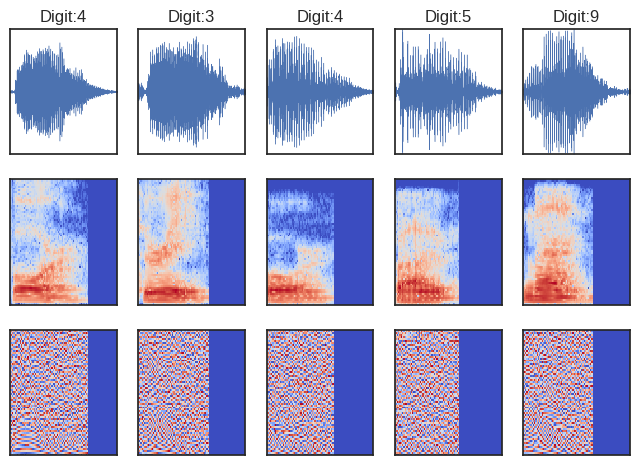

In [6]:
seaborn.set(style='white')

# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,[sidx,sidx])    

for i,j in enumerate(sidx):
    if i<k:
        plt.subplot(3,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        plt.title('Digit:{1}'.format(j,df.Class[j]))
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().get_xaxis().set_visible(False)

    elif (i>=k and i<2*k):
        plt.subplot(3,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        
    else:
        plt.subplot(3,k,i+1)
        specshow(df.Phase[j],sr=sr)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])        

In [7]:
# np.max(df.Magnitude[j])
# np.max(df.Phase[j])

In [8]:
# Play back an example!
j = sidx[1]
IPython.display.Audio(data=df.Wave[j], rate=sr)

## VAE for Audio

In [9]:
# Imports
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

from keras import metrics
# from keras.datasets import mnist
from sklearn.utils import shuffle
from scipy.stats import norm

Using TensorFlow backend.


In [10]:
chns, rows, cols = 1, 64, 84
filters = 8

batch_size = 10
latent_dim = 10
middle_dim = 128

epochs = 25
epsilon_std = 1.0
img_size = (rows,cols,chns)

In [11]:
# x = Input(input_shape=(batch_size,)+img_size)
x = Input(shape=img_size)

# Encoder
conv1 = Conv2D(filters,(3,5),padding='same',activation='relu',strides=(2,3))(x)
conv2 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(2,2))(conv1)
conv  = Flatten()(conv2)
encoded = Dense(middle_dim,activation='relu')(conv)

# Latent Distribution
z_mean = Dense(latent_dim)(encoded)
z_lvar = Dense(latent_dim)(encoded)

In [12]:
# Gaussian Sampler
def sampling(args):
    z_mean, z_lvar = args
    bsize = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(bsize, latent_dim),
                              mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_lvar / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_lvar])

In [13]:
# Intermediate Shared Layer - Decoder
decode_h = Dense(middle_dim, activation='relu')(z)

upsample = Dense(filters*16*14, activation='relu')(decode_h)
ureshape = Reshape((16,14,filters))(upsample)

trconv1  = Conv2DTranspose(filters,3,padding='same',
                          activation='relu',strides=2)(ureshape)
trconv2  = Conv2DTranspose(filters,(3,5),padding='same',
                          activation='relu',strides=(2,3))(trconv1)

decoded  = Conv2D(chns,2,padding='same',activation='relu')(trconv2)

In [14]:
def vae_loss(x, decoded):
    x = K.flatten(x)
    decoded = K.flatten(decoded)
    gen_loss = rows * cols * metrics.binary_crossentropy(x, decoded)
    kl_loss = - 0.5 * K.mean(1 + z_lvar - K.square(z_mean) - K.exp(z_lvar), axis=-1)
    return K.mean(gen_loss + kl_loss)

# Model
vae = Model(x,decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 84, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 28, 8)     128         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 16, 14, 8)     584         conv2d_1[0][0]                   
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1792)          0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [15]:
# Encoder
encoder = Model(x,z_mean)

# Generator
# dd_in = Input(shape=(latent_dim,))
# dd = decode_h(dd_in)
# dd = ureshape(dd)
# dd = trconv1(dd)
# dd = trconv2(dd)
# dd = decoded(dd)
# generator = Model(dd_in,dd) 
generator = Model(x,decoded)

In [ ]:
# Get Training Data
# x_data = df.Magnitude.values
# x_data = np.dstack(x_data)
# x_data = x_data.transpose(2,0,1)
# x_data = x_data[...,None]         # add singleton class
# x_data = shuffle(x_data)

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Train Scaler
x_data = df.Magnitude.values
normsc = np.hstack(x_data)
scaler = MinMaxScaler().fit(normsc.T)

# Transform Data using Scaler
x_data = [scaler.transform(arr.T).T for arr in df.Magnitude.values]
x_data = np.dstack(x_data).transpose(2,0,1)

# Add Singleton & Shuffle
x_data = x_data[...,None]         # Add singleton class
x_data = shuffle(x_data)

In [17]:
vae.fit(x_data,x_data,
        shuffle=True,
        epochs=20,
        batch_size=50,
        callbacks=[TensorBoard(log_dir='/tmp/vautoeconder')])

Epoch 1/20
4509/4509 [==============================] - 5s - loss: 3998.9830     
Epoch 2/20
4509/4509 [==============================] - 5s - loss: 3220.7517     
Epoch 3/20
4509/4509 [==============================] - 5s - loss: 3174.3278     
Epoch 4/20
4509/4509 [==============================] - 5s - loss: 3148.4881     
Epoch 5/20
4509/4509 [==============================] - 5s - loss: 3131.5043     
Epoch 6/20
4509/4509 [==============================] - 5s - loss: 3119.0716     
Epoch 7/20
4509/4509 [==============================] - 5s - loss: 3107.9301     
Epoch 8/20
4509/4509 [==============================] - 5s - loss: 3100.0504     
Epoch 9/20
4509/4509 [==============================] - 5s - loss: 3092.7387     
Epoch 10/20
4509/4509 [==============================] - 5s - loss: 3086.6032     
Epoch 11/20
4509/4509 [==============================] - 5s - loss: 3080.9435     
Epoch 12/20
4509/4509 [==============================] - 5s - loss: 3076.6617     
Epoch 13/20
4

In [18]:
xx = generator.predict(x_data[:10])

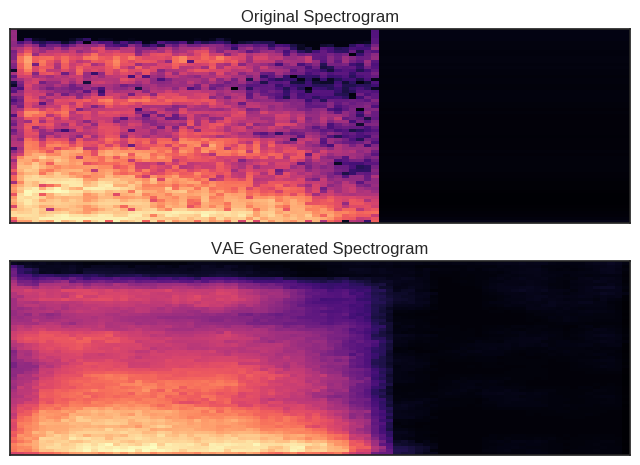

In [20]:
k = 0 
plt.subplot(211)
plt.title('Original Spectrogram')
ss=x_data[k].squeeze()
specshow(ss,sr=sr)

plt.subplot(212)
plt.title('VAE Generated Spectrogram')
ss=xx[k].squeeze()
specshow(ss,sr=sr)

In [21]:
mus = encoder.predict(x_data[:10])

In [22]:
mus[5]

array([  5.80574751,   0.80416858,  10.33749866,  -0.11747511,
        12.42486858,   0.29923758,   0.55605775,   3.29918408,
        -7.82574081,   1.11467838], dtype=float32)